# **DeepLabV3**
# Rethinking Atrous Convolution for Semantic Image Segmentation

1. ResNet_50
2. ASPP
3. DeepLabV3

- 코드 구현 참고 : https://github.com/AvivSham/DeepLabv3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from google.colab import files
from torch.optim.lr_scheduler import LambdaLR
import glob
import matplotlib.gridspec as gridspec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ResNet_50

In [ ]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, .02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.constant_(0)

In [ ]:
class ResNet_50 (nn.Module):
  def __init__(self, in_channels = 3, conv1_out = 64):
    super(ResNet_50,self).__init__()
    
    self.resnet_50 = models.resnet50(pretrained = True)
    
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self,x):
    print ("\norigin : ",x.shape)

    x = self.relu(self.resnet_50.bn1(self.resnet_50.conv1(x)))
    print ("\nrelu : ",x.shape)

    x = self.resnet_50.maxpool(x)
    print ("\nmaxpooling : ",x.shape)

    x = self.resnet_50.layer1(x)
    print ("\nlayer1 : ",x.shape)

    x = self.resnet_50.layer2(x)
    print ("\nlayer2 : ",x.shape)

    x = self.resnet_50.layer3(x)
    print ("\nlayer3 : ",x.shape,"\n")

    
    return x

In [ ]:
noise = torch.randn(1, 3, 512, 512)
m = ResNet_50()
out = m(noise)
out.shape

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth




origin :  torch.Size([1, 3, 512, 512])

relu :  torch.Size([1, 64, 256, 256])

maxpooling :  torch.Size([1, 64, 128, 128])

layer1 :  torch.Size([1, 256, 128, 128])

layer2 :  torch.Size([1, 512, 64, 64])

layer3 :  torch.Size([1, 1024, 32, 32]) 



torch.Size([1, 1024, 32, 32])

# ASPP (Atrous Spatial Pyramid Pooling)

DeepLabV2

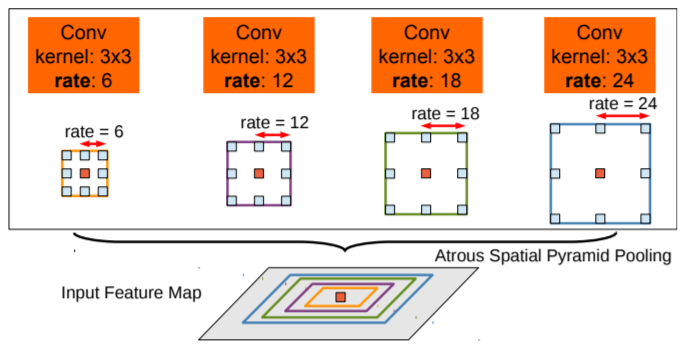

DeepLabV3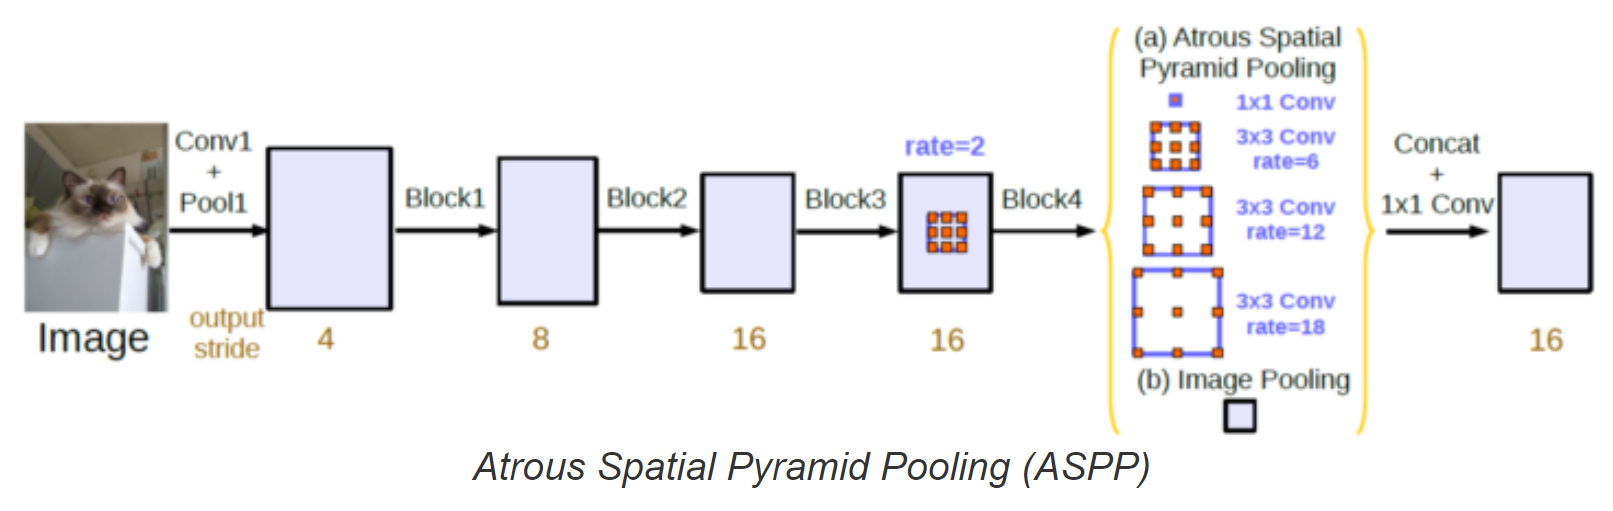


In [ ]:
class ASSP(nn.Module):
  def __init__(self,in_channels,out_channels = 256):
    super(ASSP,self).__init__()
    
    
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 6,
                          dilation = 6,
                          bias=False)
    
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.conv3 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 12,
                          dilation = 12,
                          bias=False)
    
    self.bn3 = nn.BatchNorm2d(out_channels)
    
    self.conv4 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 18,
                          dilation = 18,
                          bias=False)
    
    self.bn4 = nn.BatchNorm2d(out_channels)
    
    self.conv5 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn5 = nn.BatchNorm2d(out_channels)
    
    self.convf = nn.Conv2d(in_channels = out_channels * 5, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bnf = nn.BatchNorm2d(out_channels)
    
    self.adapool = nn.AdaptiveAvgPool2d(1)  
   
  
  def forward(self,x):
    # shape: (batch_size, out_channels, height/output_stride, width/output_stride)
    # 1번 branch
    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.relu(x1)
    # 2번 branch
    x2 = self.conv2(x)
    x2 = self.bn2(x2)
    x2 = self.relu(x2)
    # 3번 branch
    x3 = self.conv3(x)
    x3 = self.bn3(x3)
    x3 = self.relu(x3)
    # 4번 branch
    x4 = self.conv4(x)
    x4 = self.bn4(x4)
    x4 = self.relu(x4)

    # final branch
    x5 = self.adapool(x)
    x5 = self.conv5(x5)
    x5 = self.bn5(x5)
    x5 = self.relu(x5)
    x5 = F.interpolate(x5, size = tuple(x4.shape[-2:]), mode='bilinear')
    
    print ("x1 : ",x1.shape,"\nx2 : ", x2.shape,"\nx3 : ", x3.shape,"\nx4 : ", x4.shape,"\nfinal : ", x5.shape,"\n")
    # multibranch에서 나온 결과를 concat
    x = torch.cat((x1,x2,x3,x4,x5), dim = 1) 
    x = self.convf(x)
    x = self.bnf(x)
    x = self.relu(x)
    
    return x

In [ ]:
noise = torch.randn(2, 3, 32, 32, device='cpu')
m = ASSP(3).to('cpu')
out = m(noise)
out.shape

x1 :  torch.Size([2, 256, 32, 32]) 
x2 :  torch.Size([2, 256, 32, 32]) 
x3 :  torch.Size([2, 256, 32, 32]) 
x4 :  torch.Size([2, 256, 32, 32]) 
final :  torch.Size([2, 256, 32, 32]) 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 256, 32, 32])

# DeepLabV3

In [ ]:
class DeepLabv3(nn.Module):
  
  def __init__(self, nc):
    ## ResNet_50 위에 ASPP 쌓기
    super(DeepLabv3, self).__init__()
    
    self.nc = nc
    
    self.resnet = ResNet_50()
    
    self.assp = ASSP(in_channels = 1024)
    
    self.conv = nn.Conv2d(in_channels = 256, out_channels = self.nc,
                          kernel_size = 1, stride=1, padding=0)    
    
    
    for module in self.assp.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
      elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, mean=0.01, std=0.02)
        nn.init.constant_(module.bias, 0)
        
    nn.init.normal_(self.conv.weight, mean=0.0, std=0.02)
   
        
  def forward(self,x):
    _, _, h, w = x.shape
    x = self.resnet(x)
    x = self.assp(x)
    x = self.conv(x)
    x = F.interpolate(x, size=(h, w), mode='bilinear') #scale_factor = 16, mode='bilinear'
    return x

In [ ]:
noise = torch.randn(2, 3, 360, 360, device='cpu')
m = DeepLabv3(12).to('cpu')
out = m(noise)
out.shape


origin :  torch.Size([2, 3, 360, 360])

relu :  torch.Size([2, 64, 180, 180])

maxpooling :  torch.Size([2, 64, 90, 90])

layer1 :  torch.Size([2, 256, 90, 90])

layer2 :  torch.Size([2, 512, 45, 45])

layer3 :  torch.Size([2, 1024, 23, 23]) 

x1 :  torch.Size([2, 256, 23, 23]) 
x2 :  torch.Size([2, 256, 23, 23]) 
x3 :  torch.Size([2, 256, 23, 23]) 
x4 :  torch.Size([2, 256, 23, 23]) 
final :  torch.Size([2, 256, 23, 23]) 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 12, 360, 360])